In [1]:

from bs4 import BeautifulSoup
import sqlite3
import requests
import pandas as pd
from random import randint
import time
from time import sleep
from typing import List
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model, metrics, preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import r2_score, f1_score

In [2]:
def sleepms(milliseconds: int):
    seconds = 0.001 * milliseconds
    sleep(seconds)
    
def random_wait():
    start = time.time()
    sleepms(randint(1, 350))

def getFakeUser():
    return {"User-Agent":"PostmanRuntime/7.29.0"}


def getRetHeaders():
    url='https://www.ret.co.il/m/91935/specs'
    page = requests.get(url, headers = getFakeUser())
    soup= BeautifulSoup(page.content,'html.parser')
    product=soup.find('div',class_='single-product-tab')
    data=product.findAll('ul','list-group list-group-horizontal')
    myheaders= ['מחיר מינימלי','מחיר מקסימלי']
    for alldata in data:
        myheaders.append(alldata.find('span',class_='text-dark font-weight-bold').text.strip())
    return myheaders


def getUrl(url):
    page = requests.get(url, headers = getFakeUser())
    soup= BeautifulSoup(page.content,'html.parser')
    MainClass=soup.find('ul', class_='nav nav-pills mb-2 justify-content-around justify-content-md-start col-xxl-10 offset-xxl-1 col-md-12 offset-md-0')
    ref=[]
    data=MainClass.find('a')
    technicalDataPage='https://www.ret.co.il'+data.get('href')
    return technicalDataPage

def getRetData(url):
    technicalDataPage=getUrl(url)
    page = requests.get(technicalDataPage, headers = getFakeUser())
    soup= BeautifulSoup(page.content,'html.parser')
    product=soup.find('div',class_='single-product-tab')
    dataLink=product.findAll('ul',class_='list-group list-group-horizontal')
    MinMaxP=MinMaxRetPrices(url)
    mydata=[MinMaxP[0],MinMaxP[1]]
    myheaders=[]
    for alldata in dataLink:
        try:
            mydata.append(alldata.find('li',class_='list-group-item col-8 rounded-0 text-600').text.strip())
        except:
             mydata.append('None')
    return mydata

def MinMaxRetPrices(url):
    page = requests.get(url, headers = getFakeUser())
    soup= BeautifulSoup(page.content,'html.parser')
    MainClass=soup.find('div',class_='')
    MainClass=soup.find('div',class_='card-body p-0 p-sm-3')
    price=MainClass.find('div',class_='price')
    if(price==None):
        return [None,None]
    else:
        price=price.text.strip()
        price=price.replace(',','')
        prices=price.split()
        MinPrice=prices[0]
        MaxPrice=prices[3]
        priceArray=MinPrice,MaxPrice
        return priceArray


In [3]:
def getRetToDataFrame(phonesURL):
    hrefLinks=[]
    allRetData=[]
    page = requests.get(phonesURL, headers = getFakeUser())
    soup= BeautifulSoup(page.content,'html.parser')
    MainClass=soup.findAll('a')
    for href in MainClass:
        if('/m/' in href.get('href')):
            hrefLinks.append('https://www.ret.co.il' + href.get('href'))
    for hrefLink in hrefLinks:
        allRetData.append(getRetData(hrefLink))
    return allRetData


In [4]:
def mainFunc(page_num_ret):
    head=getRetHeaders()
    url=f"https://www.ret.co.il/shop/cellphone?pageindex={page_num_ret}"
    data=getRetToDataFrame(url)
    df=pd.DataFrame(data,columns=head)
    return df

In [ ]:
df_ret=mainFunc(1)
for i in range(2,10):
    df_ret=df_ret.append(mainFunc(i))
    random_wait()

In [212]:
def get_headers():
    url="https://www.zap.co.il/compmodels.aspx?modelid=1142728"
    page = requests.get(url, headers = getFakeUser())
    soup= BeautifulSoup(page.content,'html.parser')
    All_headers=['מחיר מינימלי','מחיר מקסימלי']
    headers=soup.find_all('div',class_="detailsRow")
    for header in headers:
        All_headers.append(header.find('div',class_="detailsRowTitletxt").text.strip())
    return All_headers


In [213]:
def get_properites_from_link(url):
    All_data=[]
    All_headers=[]
    page = requests.get(url, headers = getFakeUser())
    soup= BeautifulSoup(page.content,'html.parser')
    headers=soup.find_all('div',class_="detailsRow")
    titles = ['מחיר מינימלי','מחיר מקסימלי']
    prices = soup.find('div','PricesTxt').findAll('span') 
    if len(prices) == 2:
        All_data = [ prices[1].text, prices[0].text ]
    elif len(prices) == 1: 
        All_data = [ prices[0].text, prices[0].text ]
    else:
        All_data = [ None,None ]
    for header in headers:
        All_headers.append(header.find('div',class_="detailsRowTitletxt").text.strip())
        All_data.append(header.find('div',class_="detailsRowTxt").text.strip())
    return All_data

In [214]:
def get_data_from_zap(phonesURL):
    hrefLinks=[]
    all_zap_Data=[]
    Main_Url="https://www.zap.co.il"
    page = requests.get(phonesURL, headers = getFakeUser())
    soup= BeautifulSoup(page.content,'html.parser')
    links=soup.find_all('div',class_="MoreInfo")
    for link in links:
        hrefLinks.append(Main_Url+(link.find('a')['href']))
    for link in hrefLinks:
        all_zap_Data.append(get_properites_from_link(link))
    return all_zap_Data
    

In [215]:
def get_details_from_current_page(page_num_zap):
    url="https://www.zap.co.il/models.aspx?sog=e-cellphone&pageinfo={page_num_zap}"
    data=get_data_from_zap(url)
    df=pd.DataFrame(data,columns=get_headers())
    return df


Changing all the headers in the DataFrame from Hebrew to English

In [231]:

def change_CSV_File_Headers(df):
    df.rename(columns={"פוקוס אוטומטי": "Autofocus"}, inplace=True)
    df.rename(columns={"פלאש": "Flash"}, inplace=True)
    df.rename(columns={"מצלמה": "Camera"}, inplace=True)
    df.rename(columns={"מפעיל": "operator"}, inplace=True)
    df.rename(columns={"דור": "Generation"}, inplace=True)
    df.rename(columns={"סוג רשת": "Network kind"}, inplace=True)
    df.rename(columns={"כרטיס SIM": "SIM"},inplace=True)
    df.rename(columns={"רדיו FM": "FM radio"}, inplace=True)
    df.rename(columns={"גובה": "height"}, inplace=True)
    df.rename(columns={"רוחב": "width"}, inplace=True)
    df.rename(columns={"עובי": "thickness"}, inplace=True)
    df.rename(columns={"משקל": "wheight"}, inplace=True)
    df.rename(columns={"קיבולת סוללה": "Battery capacity"}, inplace=True)
    df.rename(columns={"סוללה נשלפת": "Removable battery"}, inplace=True)
    df.rename(columns={"רמקול חיצוני": "External speaker"}, inplace=True)
    df.rename(columns={"חיבור 3.5": "connection 3.5"},inplace=True)
    df.rename(columns={"מחיר מינימלי": "Minprice"}, inplace=True)
    df.rename(columns={"מחיר מקסימלי": "Maxprice"}, inplace=True)
    df.rename(columns={"יצרן": "Brand"}, inplace=True)
    df.rename(columns={"שנת הכרזה": "Declaration year"}, inplace=True)
    df.rename(columns={"מערכת הפעלה": "Operating System"}, inplace=True)
    df.rename(columns={"סדרה": "series"}, inplace=True)
    df.rename(columns={"מבנה המכשיר": "device structure"},inplace=True)
    df.rename(columns={"ממשק הפעלה": "operating interfaceo"}, inplace=True)
    df.rename(columns={"נפח אחסון פנימי": "Internal storage volume"}, inplace=True)
    df.rename(columns={"ערכת שבבים": "chipset"}, inplace=True)
    df.rename(columns={"צבעים": "colors"}, inplace=True)
    df.rename(columns={"טלפון כשר": "kosher phone"}, inplace=True)
    df.rename(columns={"רמת קרינה (SAR)": "radiation level"}, inplace=True)
    df.rename(columns={"טלפון למבוגרים": "Phone for adults"}, inplace=True)
    df.rename(columns={"מאיץ גרפי": "Graphics accelerator"}, inplace=True)
    df.rename(columns={"מהירות מעבד": "CPU speed"},inplace=True)
    df.rename(columns={"עמידות במים": "Water resistance"}, inplace=True)
    df.rename(columns={"קורא טביעת אצבע": "Fingerprint reader"},inplace=True)
    df.rename(columns={"גודל מסך": "screen size"}, inplace=True)
    df.rename(columns={"סוג מסך": "screen type"}, inplace=True)
    df.rename(columns={"קצב רענון": "refresh rate"}, inplace=True)
    df.rename(columns={"צפיפות פיקסלים": "Pixel density"}, inplace=True)
    df.rename(columns={"מפתח צמצם": "Aperture key"}, inplace=True)
    df.rename(columns={"מעבד": "Processor"}, inplace=True)
    df.rename(columns={"רזולוציה": "resolution"},inplace=True)
    df.rename(columns={"כרטיס זיכרון":"Memory Card"}, inplace=True)
    df.rename(columns={"זיכרון RAM": "RAM memory"}, inplace=True)
    df.rename(columns={"וידאו": "video"}, inplace=True)
    df.rename(columns={"קיבולת הסוללה": "battery capacity"}, inplace=True)
    df.rename(columns={"מספר ליבות": "number of cores"}, inplace=True)
    df.rename(columns={"מצלמה קדמית": "front camera"}, inplace=True)
    df.rename(columns={"טעינה אלחוטית": "wireless charging"}, inplace=True)
    df.to_csv("PhonesDF.csv",index=False)


In [ ]:
df_zap=get_details_from_current_page(1)
for i in range(2,21):
    df_zap=df_zap.append(get_details_from_current_page(i))
    random_wait()

Saving the first DataFrame before cleaning

In [5]:
def SaveDataFrame(df):
    df=df_zap.append(df_ret)
    df.to_csv('PhonesDF.csv',header=True)
    df=pd.read_csv('PhonesDF.csv')
    change_CSV_File_Headers(df)
    df=pd.read_csv('PhonesDF.csv')
    df


Function to clean all the Data Frame None price columns

In [2]:
def CleanTheDF(df):
    df=df.drop_duplicates()
    df.dropna(axis=0, how='all')# if all the values are None remove this row
    df=df.dropna(subset=['Minprice','Maxprice'],how ='all')
    df.drop(columns=['Unnamed: 0'],axis=1,inplace=True)
    df.to_csv('SmallPhonesDF.csv')
    return df
    

In [3]:
df=pd.read_csv('PhonesDF.csv')
Smalldf=CleanTheDF(df)

Cleaning and converting to Numeric

In [5]:
def cleaning_to_numeric(df):
    df['Internal storage volume']=df['Internal storage volume'].apply(lambda x: x.removesuffix('GB') if x else None)
    df['Internal storage volume']=df['Internal storage volume'].apply(lambda x: x.removesuffix('1TB') if x else None)
    df['SIM'] = df['SIM'].apply(lambda x: x.replace('אופציונלי','') if isinstance(x, str) else None)
    df['SIM'] = df['SIM'].apply(lambda x: x.replace(' אחד ','') if isinstance(x, str) else None)
    df['resolution']=df['resolution'].apply(lambda x: x.removesuffix(' פיקסלים'))
    df['Camera']=df['Camera'].apply(lambda x: x.removesuffix(' מגה פיקסל') if x else None)
    df['Camera']=df['Camera'].apply(lambda x: x.removesuffix(' מגה פיקסלים') if x else None)
    df['Camera']=df['Camera'].apply(lambda x: x.removesuffix(' צגה פיקסל') if x else None)
    df['Camera']=df['Camera'].apply(lambda x: x.removesuffix(' גה פיקסל') if x else None)
    df['CPU speed']=df['CPU speed'].apply(lambda x: x.split()[0] if x else None)
    df['battery capacity']=df['battery capacity'].apply(lambda x: x.removesuffix(' mAh') if x else None)
    df['battery capacity']=df['battery capacity'].str.replace(',','')
    df['number of cores']=df['number of cores'].apply(lambda x: x.removesuffix(' ליבות') if x else None)
    df['CPU speed']=pd.to_numeric(df['CPU speed'],errors='coerce')
    df['battery capacity'] = pd.to_numeric(df['battery capacity'], errors='coerce')
    df['Camera']=pd.to_numeric(df['Camera'],errors='coerce')
    df['width']=pd.to_numeric(df['width'].str.replace('מ"מ','').str.strip(),errors='coerce')
    df['thickness']=pd.to_numeric(df['thickness'].str.replace('מ"מ','').str.strip(),errors='coerce')
    df['Flash']=pd.to_numeric(df['Flash'].str.replace('לדים','').str.strip(),errors='coerce')
    df['wheight']=pd.to_numeric(df['wheight'].str.replace('גרם','').str.strip(),errors='coerce')
    df['refresh rate']=pd.to_numeric(df['refresh rate'].str.replace('Hz','').str.strip(),errors='coerce')
    df['Pixel density']=pd.to_numeric(df['Pixel density'].str.replace('ppi','').str.strip(),errors='coerce')
    df['screen size']=pd.to_numeric(df['screen size'].str.replace('אינטש','').str.strip(),errors='coerce')
    df['Network kind']=pd.to_numeric(df['Network kind'].str.replace('G','').str.strip(),errors='coerce')
    df['front camera']=pd.to_numeric(df['front camera'].str.replace('מגה פיקסל','').str.strip(),errors='coerce')
    df['radiation level']=pd.to_numeric(df['radiation level'].str.replace('W/kg','').str.strip(),errors='coerce')
    df['RAM memory']=pd.to_numeric(df['RAM memory'].str.replace('GB','').str.strip(),errors='coerce')
    df['height']=pd.to_numeric(df['height'].str.replace('מ"מ','').str.strip(),errors='coerce')
    df['Minprice']=pd.to_numeric(df['Minprice'].str.replace(',','').str.strip(),errors='coerce')
    df['Maxprice']=pd.to_numeric(df['Maxprice'].str.replace(',','').str.strip(),errors='coerce')
  #?  df['width']=pd.to_numeric(df['width'],errors='coerce')      דוד תבדוק מה הבעיה שאמרת שהייתה, אמור לעבוד
  #?   df['height']=pd.to_numeric(df['height'],errors='coerce')
  #?  df['wheight']=pd.to_numeric(df['wheight'],errors='coerce')
    df['Declaration year']=pd.to_numeric(df['Declaration year'],errors='coerce')
    df['number of cores']=pd.to_numeric(df['number of cores'],errors='coerce')

    return df



In [6]:
def lastCleanning(df_WithNone):
    df_WithNone["Autofocus"] =  np.where(df_WithNone['Autofocus']  == "כולל" , 1 , 0)
    df_WithNone["connection 3.5"] =  np.where(df_WithNone['connection 3.5']  == "ללא" , 0 , 1)
    df_WithNone["Dual-SIM"] =  np.where(df_WithNone['Dual-SIM']  == "ללא" , 0 , 1)
    df_WithNone["Memory Card"] =  np.where(df_WithNone['Memory Card']  == "ללא" , 0 , 1)
    df_WithNone["Fingerprint reader"] =  np.where(df_WithNone['Fingerprint reader']  == "ללא" , 0 , 1)
    df_WithNone["WiFi"] =  np.where(df_WithNone['WiFi']  == "כולל" , 1 , 0)
    df_WithNone["IR"] =  np.where(df_WithNone['IR']  == "לא כולל" , 0 , 1)
    df_WithNone["GPS"] =  np.where(df_WithNone['GPS']  == "כולל" , 1 , 0)
    df_WithNone["NFC"] =  np.where(df_WithNone['NFC']  == "כולל" , 1 , 0)
    df_WithNone['Smartphone'] =  np.where(df_WithNone['Smartphone']  == 'סמארטפון' , 1 , 0)
    df_WithNone["FM radio"] =  np.where(df_WithNone['FM radio']  == "ללא רדיו" , 0 , 1)
    df_WithNone["Removable battery"] =  np.where(df_WithNone['Removable battery']  == "לא" , 0 , 1)
    df_WithNone["wireless charging"] =  np.where(df_WithNone['wireless charging']  == "כולל" , 1 , 0)
    df_WithNone["External speaker"] =  np.where(df_WithNone['External speaker']  == "ללא" , 0 , 1)
    df_WithNone["kosher phone"] =  np.where(df_WithNone['kosher phone']  == "טלפון כשר" , 1, 0)
    df_WithNone["colors"] = np.where( df_WithNone['colors']!= None, 1, 0)
    df_WithNone["Phone for adults"] = np.where(df_WithNone['Phone for adults']== "טלפון למבוגרים", 1, 0)
    df_WithNone["operating interfaceo"] = np.where( df_WithNone['operating interfaceo']== "מסך מגע", 1, 0)
    for col in df_WithNone:
        df_WithNone.loc[(df_WithNone[col] == 'לא זמין') |(df_WithNone[col] == 'יעודכן בקרוב'),col]=None
    for i in df_WithNone.index:
        try:
            df_WithNone['number of cores'][i]=eval(df_WithNone['number of cores'][i])
        except:
            continue
    for i in df_WithNone.index:
        try:
            df_WithNone['resolution'][i]=eval(df_WithNone['resolution'][i].replace('x','*'))
        except: 
            if df_WithNone['resolution'][i]!= None:
                a = df_WithNone['resolution'][i].split('x')
                b = a[1].split('\u200f')
                df_WithNone['resolution'][i]=(int(a[0])*int(b[0]))
    for i in df_WithNone.index:
        if df_WithNone['Internal storage volume'][i]!='None':
            df_WithNone['Internal storage volume'][i]=int(df_WithNone['Internal storage volume'][i])
        else:
            df_WithNone['Internal storage volume'][i]=None
    df_WithNone['resolution']=pd.to_numeric(df['resolution'],errors='coerce')

    return df_WithNone



In [7]:
def to_float(x):
    try:
        return float(x)
    except:
        return x

In [ ]:

df_WithNone = Smalldf.copy()
df_WithNone=cleaning_to_numeric(df_WithNone)
df_WithNone=lastCleanning(df_WithNone)
#pd.set_option('display.max_rows',None)
#pd.set_option('display.max_columns',None)
df_WithNone['battery capacity'] = df_WithNone['battery capacity'].apply(to_float)

In [22]:
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
df_WithNone.describe()

,Minprice,Maxprice,Declaration year,Smartphone,radiation level,operating interfaceo,kosher phone,colors,Phone for adults,number of cores,CPU speed,RAM memory,Memory Card,Fingerprint reader,screen size,resolution,Pixel density,refresh rate,Network kind,WiFi,IR,GPS,NFC,Camera,Flash,Autofocus,front camera,connection 3.5,External speaker,FM radio,height,width,thickness,wheight,battery capacity,Removable battery,wireless charging,Dual-SIM
count,429.000000,429.000000,310.000000,429.000000,127.000000,429.000000,429.000000,429.0,429.000000,59.000000,273.000000,376.000000,429.000000,429.000000,398.000000,0.0,391.000000,181.000000,62.0,429.000000,429.000000,429.000000,429.000000,55.000000,42.0,429.000000,29.000000,429.000000,429.000000,429.000000,378.000000,392.000000,398.000000,398.000000,347.000000,429.000000,429.000000,429.000000
mean,2114.934732,1674.153846,2019.561290,0.890443,0.698228,0.864802,0.020979,1.0,0.037296,7.050847,2186.560806,6.425532,0.568765,0.867133,6.070352,NaN,393.634271,107.370166,5.0,0.916084,0.571096,0.909091,0.587413,8.351818,4.0,0.482517,17.275862,0.510490,0.995338,0.426573,155.932540,73.401786,8.654749,183.820352,4110.458213,0.104895,0.370629,0.752914
std,1592.839440,1310.297102,2.187294,0.312702,0.376060,0.342334,0.143481,0.0,0.189707,1.906647,477.522536,2.667291,0.495827,0.339827,1.142000,NaN,87.687304,16.964702,0.0,0.277586,0.495497,0.287815,0.492875,5.053299,0.0,0.500278,10.201178,0.500474,0.068199,0.495157,13.239346,7.871352,2.745878,30.772489,1158.255560,0.306776,0.483537,0.431821
min,108.000000,39.000000,2007.000000,0.000000,0.220000,0.000000,0.000000,1.0,0.000000,2.000000,1.100000,2.000000,0.000000,0.000000,1.770000,NaN,111.000000,60.000000,5.0,0.000000,0.000000,0.000000,0.000000,0.300000,4.0,0.000000,8.000000,0.000000,0.000000,0.000000,76.000000,44.700000,6.400000,70.200000,430.000000,0.000000,0.000000,0.000000
25%,929.000000,770.000000,2019.000000,1.000000,0.360000,1.000000,0.000000,1.0,0.000000,6.000000,1800.000000,4.000000,0.000000,1.000000,6.100000,NaN,393.000000,90.000000,5.0,1.000000,0.000000,1.000000,0.000000,2.000000,4.0,0.000000,10.000000,0.000000,1.000000,0.000000,151.700000,71.725000,7.800000,174.250000,3700.000000,0.000000,0.000000,1.000000
50%,1600.000000,1290.000000,2020.000000,1.000000,0.590000,1.000000,0.000000,1.0,0.000000,8.000000,2000.000000,6.000000,1.000000,1.000000,6.450000,NaN,403.000000,120.000000,5.0,1.000000,1.000000,1.000000,1.000000,12.000000,4.0,0.000000,12.000000,1.000000,1.000000,0.000000,160.200000,74.800000,8.200000,189.000000,4500.000000,0.000000,0.000000,1.000000
75%,2899.000000,2145.000000,2021.000000,1.000000,0.990000,1.000000,0.000000,1.0,0.000000,8.000000,2700.000000,8.000000,1.000000,1.000000,6.670000,NaN,458.000000,120.000000,5.0,1.000000,1.000000,1.000000,1.000000,12.000000,4.0,1.000000,20.000000,1.000000,1.000000,1.000000,163.700000,76.100000,8.800000,199.000000,5000.000000,0.000000,1.000000,1.000000
max,7850.000000,7850.000000,2022.000000,1.000000,1.630000,1.000000,1.000000,1.0,1.000000,10.000000,3090.000000,16.000000,1.000000,1.000000,7.600000,NaN,570.000000,144.000000,5.0,1.000000,1.000000,1.000000,1.000000,16.000000,4.0,1.000000,40.000000,1.000000,1.000000,1.000000,192.700000,128.200000,54.000000,282.000000,6000.000000,1.000000,1.000000,1.000000


After using the pd.to_numeric all the values that werent changed got changed into NAN values and we also saw that we good 'None' values as a string insted of None this rows change them back to None

In [38]:
df_WithNone = df_WithNone.replace({np.nan:None})
df_WithNone=df_WithNone.replace('None', None)

In [ ]:
list_describe=df_WithNone.describe().columns
all_cols=df_WithNone.columns
listNotInDescribe=[]
for col in all_cols:
    if(col not in list_describe):
        listNotInDescribe.append(col)
df_WithNone


its look that we have a lot of cols that not in our describe so we will want to try to fillna

we will want to drop the unnecessary cols 

In [24]:
df_WithNone=df_WithNone.drop(['radiation level','Phone for adults'
,'wireless charging','Aperture key','device structure','Declaration year','SIM'],axis=1)

now we want to fillna some nan like battery

108
7850


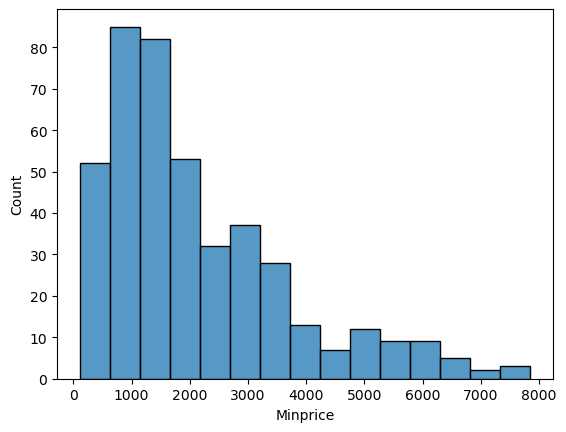

In [150]:
print(df_WithNone["Minprice"].min())
print(df_WithNone['Minprice'].max())
sns.histplot(df_WithNone['Minprice'])
plt.show()

its like we will know which what to fill the nan vals

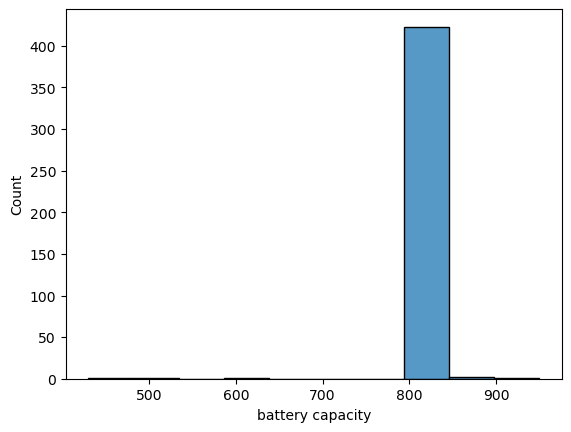

In [104]:
most_freq = df_WithNone['battery capacity'].mode()[0]
df_WithNone['battery capacity'] = df_WithNone['battery capacity'].fillna(most_freq)
sns.histplot(df_WithNone['battery capacity'])
plt.show()

We decided to combain the MinPrice and MaxPrice into an avarage price.

In [46]:
dfUnionPrice=df_WithNone.copy()
dfUnionPrice['Price']=(dfUnionPrice['Minprice'] + dfUnionPrice['Maxprice'])/2
dfUnionPrice=dfUnionPrice.drop(['Minprice','Maxprice'],axis=1)
dfUnionPrice.describe()

,Brand,Operating System,Declaration year,device structure,series,Smartphone,radiation level,operating interfaceo,kosher phone,colors,Phone for adults,Internal storage volume,chipset,Processor,number of cores,CPU speed,Graphics accelerator,RAM memory,Memory Card,Water resistance,Fingerprint reader,screen size,screen type,resolution,Pixel density,refresh rate,SIM,Network kind,Generation,operator,WiFi,Bluetooth,IR,GPS,NFC,Camera,Flash,Autofocus,Aperture key,video,front camera,connection 3.5,External speaker,FM radio,height,width,thickness,wheight,battery capacity,Removable battery,wireless charging,Dual-SIM,Price
count,414,389,310.0,412,250,429.0,127.00,429.0,429.0,429.0,429.0,388,300,262,59.0,273.0,295,376.0,429.0,306,429.0,398.0,381,0,391.0,181.0,28,62.0,391,26,429.0,396,429.0,429.0,429.0,55.0,42.0,429.0,347,394,29.0,429.0,429.0,429.0,378.0,392.0,398.0,398.0,347.0,429.0,429.0,429.0,429.0
unique,16,4,13.0,6,118,2.0,54.00,2.0,2.0,1.0,2.0,7,89,46,5.0,31.0,43,7.0,2.0,7,2.0,47.0,26,0,76.0,4.0,4,1.0,5,1,2.0,12,2.0,2.0,2.0,12.0,1.0,2.0,70,17,8.0,2.0,2.0,2.0,123.0,91.0,50.0,97.0,67.0,2.0,2.0,2.0,389.0
top,Samsung,Android,2020.0,פאבלט,Galaxy S20,1.0,0.99,1.0,0.0,1.0,0.0,128,Apple A15 Bionic,Cortex-A76 Cortex-A55,8.0,2000.0,Apple GPU,8.0,1.0,IP68,1.0,6.7,Super AMOLED,NaN,395.0,120.0,Dual SIM,5.0,4,"רמי לוי , פלאפון , הוט מובייל , גולן טלקום , ס...",1.0,5.0,1.0,1.0,1.0,12.0,4.0,0.0,1.8 2.2 2.4 2.4‏ /f,2160p@60fps,12.0,1.0,1.0,0.0,164.2,71.5,7.9,190.0,5000.0,0.0,0.0,1.0,499.0
freq,122,305,92.0,348,13,382.0,8.00,371.0,420.0,429.0,413.0,185,22,23,35.0,63.0,32,121.0,244.0,128,372.0,48.0,72,NaN,34.0,109.0,13,62.0,308,26,393.0,213,245.0,390.0,252.0,19.0,42.0,222.0,40,135,10.0,219.0,427.0,246.0,17.0,24.0,37.0,18.0,108.0,384.0,270.0,323.0,3.0
